# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [4]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

## Time series analysis

Load the data from "Price of Weed".

In [5]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


The following function takes a DataFrame of transactions and compute daily averages.

In [6]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

The following function returns a map from quality name to a DataFrame of daily averages.

In [7]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

`dailies` is the map from quality name to DataFrame.

In [8]:
dailies = GroupByQualityAndDay(transactions)

The following plots the daily average price for each quality.

C:\Users\pthus\pythonProjects\dataAnalysisPractice\ThinkStats2\code\thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


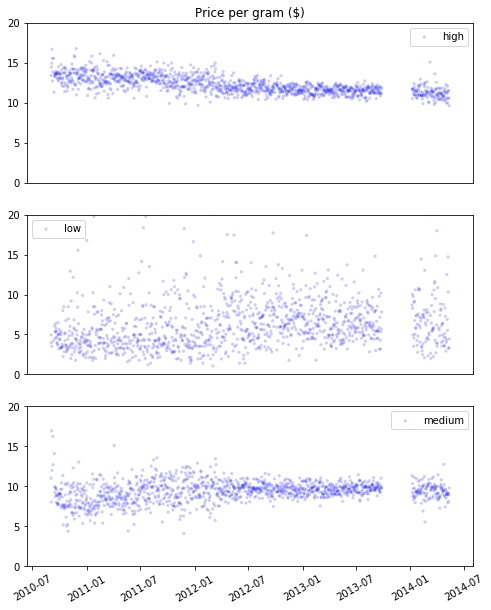

In [9]:
import matplotlib.pyplot as plt

thinkplot.PrePlot(rows=3)
for i, (name, daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'Price per gram ($)' if i == 0 else ''
    thinkplot.Config(ylim=[0, 20], title=title)
    thinkplot.Scatter(daily.ppg, s=10, label=name)
    if i == 2: 
        plt.xticks(rotation=30)
        thinkplot.Config()
    else:
        thinkplot.Config(xticks=[])

In [10]:
# Mine, first create average price per day (ppd) Series with quality date multiindex
grouped_avg_ppd = transactions.groupby(['quality', 'date']).ppg.mean()

<function matplotlib.pyplot.show(*args, **kw)>

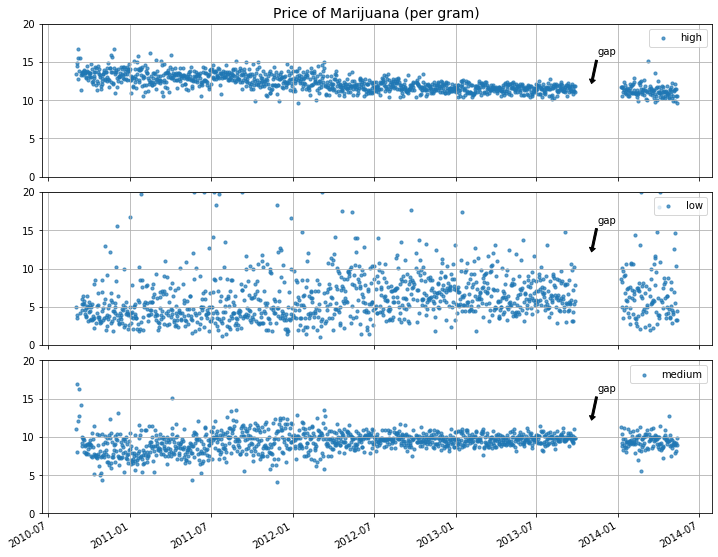

In [11]:
# Index into the grouped Series and plot
# Add labels to show high, medium, low
import datetime as dt
import matplotlib.dates as mdates

fig,axes = plt.subplots(nrows=3, sharex=True)
fig.set_size_inches(12,10)

plot_num=0
for i in grouped_avg_ppd.index.levels[0]: # selects high, medium, low quality
    axes[plot_num].scatter(grouped_avg_ppd.loc[i].index, grouped_avg_ppd.loc[i].values, s=10, alpha=0.7, label=i)
    axes[plot_num].set_ylim([0,20])
    axes[plot_num].legend(loc='upper right')
    axes[plot_num].tick_params(axis='y', labelsize=10)
    axes[plot_num].set_yticks(axes[plot_num].get_yticks()[::1])
    axes[plot_num].annotate('gap',
                            xy=(mdates.date2num(dt.datetime(2013, 11, 1)), 12),
                            xytext=(6, 30), textcoords='offset points',
                            fontsize=10,
                            arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=6, headlength=4))
    axes[plot_num].grid()
    if plot_num == 0:
        axes[plot_num].set_title('Price of Marijuana (per gram)', size=14)
    plot_num+=1

#plt.title('Price of Marijuana (per gram)')
#plt.legend()
#plt.xticks(rotation=45, size=10)
plt.subplots_adjust(hspace=0.1)

fig.autofmt_xdate()
plt.show

We can use `statsmodels` to run a linear model of price as a function of time.

In [12]:
import statsmodels.formula.api as smf

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

Here's what the results look like.

In [13]:
from IPython.display import display

for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print(name)
    display(results.summary())

high


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          3.69e-160
Time:                        05:35:57   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.080      0.000      13.361      13.539
years         -0.7082      0.023    -31.460      0.000      -0.752      -0.664
==============================================================================
Omnibus:                       56.254   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.992
Skew:                           0.252   Prob(JB):                     9.76e-29
Kurtosis:                       4.497   Cond. No.                         4.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

low


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     35.90
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.76e-09
Time:                        05:35:57   Log-Likelihood:                -3091.3
No. Observations:                1179   AIC:                             6187.
Df Residuals:                    1177   BIC:                             6197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3616      0.194     27.671      0.000       4.981       5.742
years          0.5683      0.095      5.991      0.000       0.382       0.754
==============================================================================
Omnibus:                      649.338   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6347.614
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      13.329   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

medium


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     64.92
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.82e-15
Time:                        05:35:57   Log-Likelihood:                -2053.9
No. Observations:                1238   AIC:                             4112.
Df Residuals:                    1236   BIC:                             4122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8791      0.071    125.043      0.000       8.740       9.018
years          0.2832      0.035      8.057      0.000       0.214       0.352
==============================================================================
Omnibus:                      133.025   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.863
Skew:                           0.385   Prob(JB):                    1.02e-137
Kurtosis:                       6.411   Cond. No.                         4.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Mine, I'm going to use the grouped_avg_ppd data I created earlier
# First add the years column to the data
# Then run statsmodels

In [15]:
# First have to change it from Series to DataFrame
grouped_avg_ppd_df = grouped_avg_ppd.to_frame()

In [16]:
# Now create years column
one_year = np.timedelta64(1, 'Y')
grouped_avg_ppd_df['years'] = (grouped_avg_ppd_df.index.get_level_values(level=1) - grouped_avg_ppd_df.index.get_level_values(level=1).min()) / one_year
grouped_avg_ppd_df.head()

ppg     years
quality date                           
high    2010-09-02  13.384186  0.000000
        2010-09-03  14.459588  0.002738
        2010-09-04  14.923333  0.005476
        2010-09-05  16.667500  0.008214
        2010-09-06  15.537500  0.010952

In [17]:
# Next run statsmodels, imports of statsmodels and iPython.display already done above

for i in grouped_avg_ppd_df.index.levels[0]: # selects high, medium, low quality
    model = smf.ols('ppg ~ years', data=grouped_avg_ppd_df.loc[i])
    results = model.fit()
    print(i)
    display(results.summary())

high


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     989.7
Date:                Mon, 16 Nov 2020   Prob (F-statistic):          3.69e-160
Time:                        05:35:57   Log-Likelihood:                -1510.1
No. Observations:                1241   AIC:                             3024.
Df Residuals:                    1239   BIC:                             3035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4496      0.045    296.080      0.000      13.361      13.539
years         -0.7082      0.023    -31.460      0.000      -0.752      -0.664
==============================================================================
Omnibus:                       56.254   Durbin-Watson:                   1.847
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.992
Skew:                           0.252   Prob(JB):                     9.76e-29
Kurtosis:                       4.497   Cond. No.                         4.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

low


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     35.90
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           2.76e-09
Time:                        05:35:57   Log-Likelihood:                -3091.3
No. Observations:                1179   AIC:                             6187.
Df Residuals:                    1177   BIC:                             6197.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3616      0.194     27.671      0.000       4.981       5.742
years          0.5683      0.095      5.991      0.000       0.382       0.754
==============================================================================
Omnibus:                      649.338   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6347.614
Skew:                           2.373   Prob(JB):                         0.00
Kurtosis:                      13.329   Cond. No.                         4.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

medium


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     64.92
Date:                Mon, 16 Nov 2020   Prob (F-statistic):           1.82e-15
Time:                        05:35:57   Log-Likelihood:                -2053.9
No. Observations:                1238   AIC:                             4112.
Df Residuals:                    1236   BIC:                             4122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.8791      0.071    125.043      0.000       8.740       9.018
years          0.2832      0.035      8.057      0.000       0.214       0.352
==============================================================================
Omnibus:                      133.025   Durbin-Watson:                   1.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              630.863
Skew:                           0.385   Prob(JB):                    1.02e-137
Kurtosis:                       6.411   Cond. No.                         4.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's plot the fitted model with the data.

In [18]:
def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.

    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model', color='#ff7f00')

The following function plots the original data and the fitted curve.

In [19]:
def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.
    
    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Config(title='Fitted values',
                     xlabel='Years',
                     xlim=[-0.1, 3.8],
                     ylabel='Price per gram ($)')

Here are results for the high quality category:

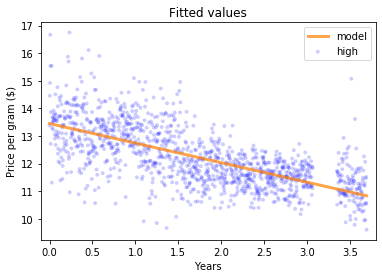

In [20]:
name = 'high'
daily = dailies[name]

PlotLinearModel(daily, name)

Text(0, 0.5, 'Price per gram')

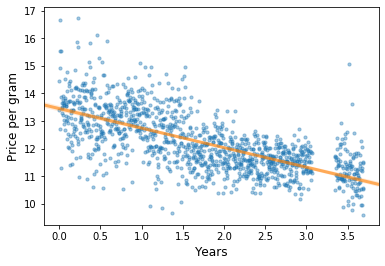

In [21]:
# I'll just plot using seaborn
# Need to adjust plot configuration and save the settings in snippets
import seaborn as sns
sns.regplot(x='years', y='ppg', data=grouped_avg_ppd_df.loc['high'],
            scatter_kws = {'s':10, 'alpha':0.4},
            line_kws = {'color':'#ff7f00', 'alpha':0.6, 'lw':3})

plt.xlabel('Years', size=12)
plt.ylabel('Price per gram', size=12)

## Moving averages

As a simple example, I'll show the rolling average of the numbers from 1 to 10.

In [22]:
array = np.arange(10)

With a "window" of size 3, we get the average of the previous 3 elements, or nan when there are fewer than 3.

In [23]:
# It looks like this doesn't exist in recent versions of Pandas

# pd.rolling_mean(array, 3)

In [24]:
# But Series now provides `rolling`

series = pd.Series(array)
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

The following function plots the rolling mean.

In [25]:
def PlotRollingMean(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed.ppg.rolling(30).mean()
    thinkplot.Plot(roll_mean, label='rolling mean', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

Here's what it looks like for the high quality category.

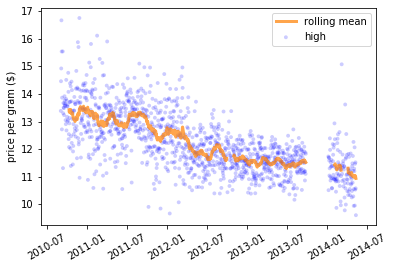

In [26]:
PlotRollingMean(daily, name)

In [27]:
# Mine, first have to reindex so that dates on which there is no data are still listed just with no value
# Because I was using a multi-index the reindexing is a bit complicated
# Found solution here: https://stackoverflow.com/questions/39441925/reindexing-a-multiindex-in-pandas-dataframe
my_dates = pd.date_range(transactions.date.min(), transactions.date.max()) # First use original data frame for date range
avg_ppd_unstacked = grouped_avg_ppd_df.unstack(level=0).reindex(my_dates)
avg_ppd_reindexed = avg_ppd_unstacked.stack(dropna=False).swaplevel().sort_index()
avg_ppd_reindexed

ppg     years
quality                                
high    2010-09-02  13.384186  0.000000
        2010-09-03  14.459588  0.002738
        2010-09-04  14.923333  0.005476
        2010-09-05  16.667500  0.008214
        2010-09-06  15.537500  0.010952
        2010-09-07  12.715000  0.013690
        2010-09-08  13.865000  0.016427
        2010-09-09        NaN       NaN
        2010-09-10        NaN       NaN
        2010-09-11  15.540000  0.024641
        2010-09-12  11.310000  0.027379
        2010-09-13  13.300000  0.030117
        2010-09-14  13.670207  0.032855
        2010-09-15  13.510101  0.035593
        2010-09-16  13.483694  0.038331
        2010-09-17  13.234431  0.041069
        2010-09-18  13.656053  0.043807
        2010-09-19  13.915778  0.046544
        2010-09-20  13.769322  0.049282
        2010-09-21  13.578381  0.052020
        2010-09-22  13.563624  0.054758
        2010-09-23  13.644103  0.057496
        2010-09-24  13.050305  0.060234
        2010-09-25  12.906000  0.062972
        2010-09-26  13.819722  0.065710
        2010-09-27  14.509123  0.068448
        2010-09-28  12.676905  0.071186
        2010-09-29  13.755075  0.073923
        2010-09-30  13.556000  0.076661
        2010-10-01  13.169030  0.079399
...                       ...       ...
medium  2014-04-14  10.033774  3.614037
        2014-04-15  10.271538  3.616775
        2014-04-16  10.829344  3.619513
        2014-04-17   9.602462  3.622251
        2014-04-18   9.746000  3.624989
        2014-04-19   9.844737  3.627727
        2014-04-20   9.030247  3.630465
        2014-04-21   9.395125  3.633203
        2014-04-22   9.513750  3.635941
        2014-04-23   9.406184  3.638678
        2014-04-24  12.764545  3.641416
        2014-04-25   9.389298  3.644154
        2014-04-26  10.209211  3.646892
        2014-04-27   8.751429  3.649630
        2014-04-28   8.889753  3.652368
        2014-04-29   7.430980  3.655106
        2014-04-30   9.658585  3.657844
        2014-05-01   9.538864  3.660582
        2014-05-02   8.515106  3.663320
        2014-05-03   9.005000  3.666057
        2014-05-04   8.931571  3.668795
        2014-05-05   9.167670  3.671533
        2014-05-06   9.262632  3.674271
        2014-05-07   8.918585  3.677009
        2014-05-08   7.928889  3.679747
        2014-05-09   9.037059  3.682485
        2014-05-10   9.155686  3.685223
        2014-05-11   8.138214  3.687961
        2014-05-12   8.959655  3.690699
        2014-05-13   9.810625  3.693437

[4050 rows x 2 columns]

Text(0, 0.5, 'Price per gram')

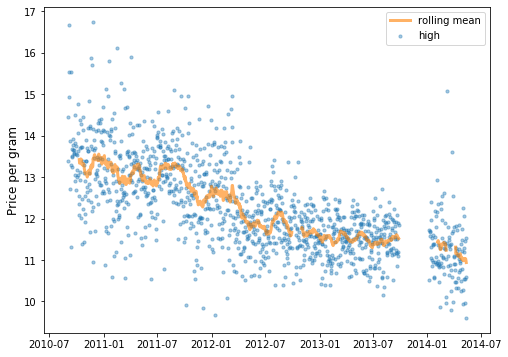

In [28]:
# Mine, rolling mean plot
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.scatter(avg_ppd_reindexed.loc['high'].index, avg_ppd_reindexed.loc['high'].ppg,
           s=10, alpha=0.4, label='high')
roll_mean = avg_ppd_reindexed.loc['high'].ppg.rolling(30).mean()
ax.plot(roll_mean, c='#ff7f00', alpha=0.6, lw=3, label='rolling mean')

plt.legend()
plt.ylabel('Price per gram', size=12)

The exponentially-weighted moving average gives more weight to more recent points.

In [29]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed.ppg.ewm(30).mean()
    thinkplot.Plot(roll_mean, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

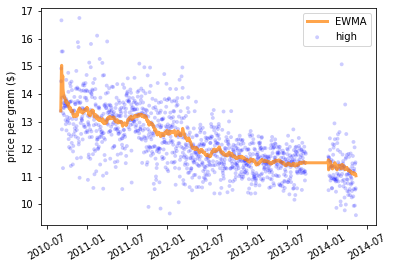

In [30]:
PlotEWMA(daily, name)

Text(0, 0.5, 'Price per gram')

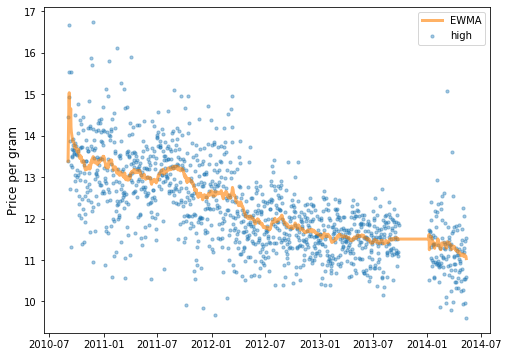

In [31]:
# Mine, EWMA
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.scatter(avg_ppd_reindexed.loc['high'].index, avg_ppd_reindexed.loc['high'].ppg,
           s=10, alpha=0.4, label='high')
roll_mean_ewm = avg_ppd_reindexed.loc['high'].ppg.ewm(30).mean()
ax.plot(roll_mean_ewm, c='#ff7f00', alpha=0.6, lw=3, label='EWMA')

plt.legend()
plt.ylabel('Price per gram', size=12)

We can use resampling to generate missing values with the right amount of noise.

In [32]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = reindexed.ppg.ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

In [33]:
# Cheking what author did for filling data
# dates = pd.date_range(daily.index.min(), daily.index.max())
# reindexed = daily.reindex(dates)
# #reindexed
# ewma = reindexed.ppg.ewm(span=30).mean()
# resid = (reindexed.ppg - ewma).dropna()
# fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
# reindexed.ppg.fillna(fake_data, inplace=True)
# reindexed['ewma'] = ewma
# reindexed['resid'] = reindexed.ppg - ewma
# reindexed

In [34]:
def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='Price per gram ($)')

Here's what the EWMA model looks like with missing values filled.

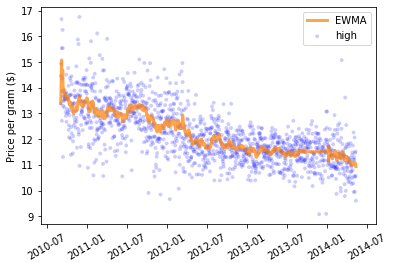

In [35]:
PlotFilled(daily, name)

In [36]:
# Mine, first fill the missing data
# Problem with mine: in a cell above the author selects only the high data as 'daily' variable, mine is all the data
# I can try to impute fake data in my whole DataFrame which would be even more complete
def FillData(df):
    df['ewma'] = np.nan
    df['resid'] = np.nan
    
    for i in df.index.levels[0]:
        ewma = df.loc[i].ppg.ewm(span=30).mean()
        resid = (df.loc[i].ppg - ewma).dropna()
        fake_data = ewma + resid.sample(n=len(df.loc[i]), replace=True).values #.values needed due to duplicates in multi-index
        df.loc[i].ppg.fillna(fake_data, inplace=True)
        
        df.loc[i, 'ewma'] = ewma.values
        df.loc[i, 'resid'] = df.loc[i].ppg.values - ewma.values
        
    return df

In [37]:
# Checking what I did for filling data
# #avg_ppd_reindexed.loc['high']
# avg_ppd_reindexed['ewma'] = np.nan
# avg_ppd_reindexed['resid'] = np.nan
# my_ewma = avg_ppd_reindexed.loc['high'].ppg.ewm(span=30).mean()
# my_resid = (avg_ppd_reindexed.loc['high'].ppg - my_ewma).dropna()
# my_fake_data = ewma + my_resid.sample(n=len(avg_ppd_reindexed.loc['high']), replace=True).values
# my_fake_data
# avg_ppd_reindexed.loc['high'].ppg.fillna(my_fake_data, inplace=True)
# avg_ppd_reindexed.loc['high', 'ewma'] = my_ewma.values
# #avg_ppd_reindexed.loc['high', 'ewma']
# avg_ppd_reindexed.loc['high', 'resid'] = avg_ppd_reindexed.loc['high'].ppg.values - my_ewma.values
# avg_ppd_reindexed
# #avg_ppd_reindexed.loc['high', 'resid']
# #avg_ppd_reindexed.loc['high'].ppg

In [38]:
# Try using new function from above
# Might be working now... need to check against authors
my_filled = FillData(avg_ppd_reindexed)
my_filled

ppg     years       ewma     resid
quality                                                     
high    2010-09-02  13.384186  0.000000  13.384186  0.000000
        2010-09-03  14.459588  0.002738  13.939810  0.519777
        2010-09-04  14.923333  0.005476  14.289742  0.633591
        2010-09-05  16.667500  0.008214  14.944901  1.722599
        2010-09-06  15.537500  0.010952  15.079732  0.457768
        2010-09-07  12.715000  0.013690  14.617109 -1.902109
        2010-09-08  13.865000  0.016427  14.487027 -0.622027
        2010-09-09  13.968071       NaN  14.487027 -0.518956
        2010-09-10  15.054559       NaN  14.487027  0.567532
        2010-09-11  15.540000  0.024641  14.670683  0.869317
        2010-09-12  11.310000  0.027379  14.142564 -2.832564
        2010-09-13  13.300000  0.030117  14.021383 -0.721383
        2010-09-14  13.670207  0.032855  13.974587 -0.304380
        2010-09-15  13.510101  0.035593  13.916672 -0.406571
        2010-09-16  13.483694  0.038331  13.865750 -0.382057
        2010-09-17  13.234431  0.041069  13.795245 -0.560814
        2010-09-18  13.656053  0.043807  13.780400 -0.124348
        2010-09-19  13.915778  0.046544  13.794255  0.121523
        2010-09-20  13.769322  0.049282  13.791796 -0.022474
        2010-09-21  13.578381  0.052020  13.771445 -0.193064
        2010-09-22  13.563624  0.054758  13.752221 -0.188597
        2010-09-23  13.644103  0.057496  13.742492 -0.098389
        2010-09-24  13.050305  0.060234  13.681752 -0.631447
        2010-09-25  12.906000  0.062972  13.615225 -0.709225
        2010-09-26  13.819722  0.065710  13.632397  0.187325
        2010-09-27  14.509123  0.068448  13.704615  0.804508
        2010-09-28  12.676905  0.071186  13.621446 -0.944541
        2010-09-29  13.755075  0.073923  13.632085  0.122989
        2010-09-30  13.556000  0.076661  13.626117 -0.070117
        2010-10-01  13.169030  0.079399  13.590758 -0.421728
...                       ...       ...        ...       ...
medium  2014-04-14  10.033774  3.614037   9.287824  0.745949
        2014-04-15  10.271538  3.616775   9.352012  0.919526
        2014-04-16  10.829344  3.619513   9.448339  1.381005
        2014-04-17   9.602462  3.622251   9.458381  0.144080
        2014-04-18   9.746000  3.624989   9.477110  0.268890
        2014-04-19   9.844737  3.627727   9.501034  0.343703
        2014-04-20   9.030247  3.630465   9.470414 -0.440167
        2014-04-21   9.395125  3.633203   9.465519 -0.070394
        2014-04-22   9.513750  3.635941   9.468653  0.045097
        2014-04-23   9.406184  3.638678   9.464596 -0.058412
        2014-04-24  12.764545  3.641416   9.678820  3.085726
        2014-04-25   9.389298  3.644154   9.660032 -0.270734
        2014-04-26  10.209211  3.646892   9.695656  0.513555
        2014-04-27   8.751429  3.649630   9.634428 -0.883000
        2014-04-28   8.889753  3.652368   9.586156 -0.696403
        2014-04-29   7.430980  3.655106   9.446494 -2.015514
        2014-04-30   9.658585  3.657844   9.460235  0.198350
        2014-05-01   9.538864  3.660582   9.465327  0.073537
        2014-05-02   8.515106  3.663320   9.403800 -0.888693
        2014-05-03   9.005000  3.666057   9.377983 -0.372983
        2014-05-04   8.931571  3.668795   9.349091 -0.417519
        2014-05-05   9.167670  3.671533   9.337351 -0.169681
        2014-05-06   9.262632  3.674271   9.332517 -0.069886
        2014-05-07   8.918585  3.677009   9.305742 -0.387158
        2014-05-08   7.928889  3.679747   9.216697 -1.287808
        2014-05-09   9.037059  3.682485   9.205081 -0.168022
        2014-05-10   9.155686  3.685223   9.201887 -0.046201
        2014-05-11   8.138214  3.687961   9.133127 -0.994912
        2014-05-12   8.959655  3.690699   9.121914 -0.162259
        2014-05-13   9.810625  3.693437   9.166424  0.644201

[4050 rows x 4 columns]

Text(0, 0.5, 'Price per gram')

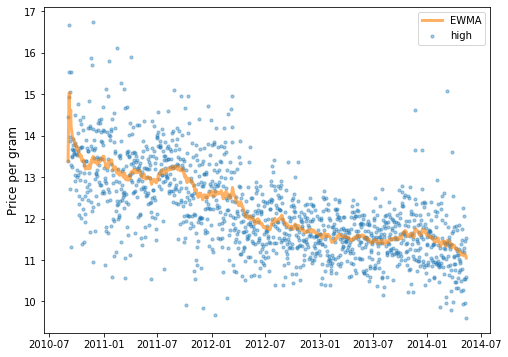

In [39]:
# Mine, plot with newly filled in data
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.scatter(my_filled.loc['high'].index, my_filled.loc['high'].ppg,
           s=10, alpha=0.4, label='high')
roll_mean_ewm = my_filled.loc['high'].ppg.ewm(30).mean()
ax.plot(roll_mean_ewm, c='#ff7f00', alpha=0.6, lw=3, label='EWMA')

plt.legend()
plt.ylabel('Price per gram', size=12)

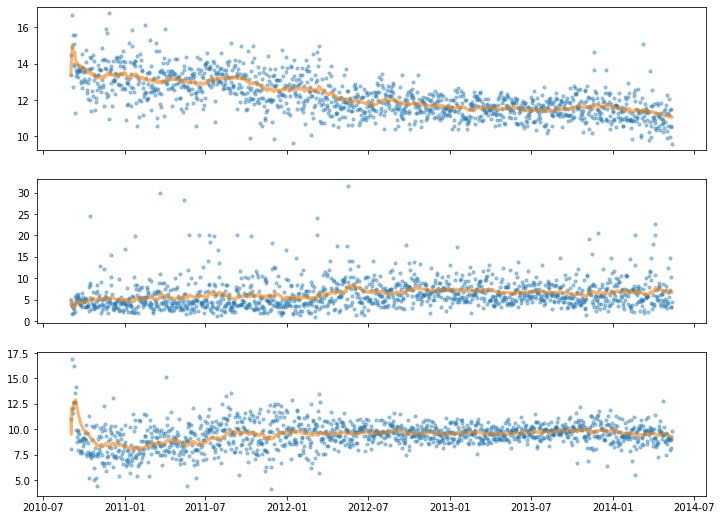

In [40]:
# Mine, plot for all qualities
fig,axes = plt.subplots(nrows=3, sharex=True)
fig.set_size_inches(12,9)

plot_num=0
for name in my_filled.index.levels[0]:
    axes[plot_num].scatter(my_filled.loc[name].index, my_filled.loc[name].ppg,
                           s=10, alpha=0.4, label=name)
    roll_mean_ewm = my_filled.loc[name].ppg.ewm(30).mean()
    axes[plot_num].plot(roll_mean_ewm, c='#ff7f00', alpha=0.6, lw=3, label='EWMA')
    
    plot_num+=1

## Serial correlation

The following function computes serial correlation with the given lag.

In [41]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

Before computing correlations, we'll fill missing values.

In [42]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

Here are the serial correlations for raw price data.

In [43]:
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)

high 0.4891840323857186
low 0.09966889655721237
medium 0.16702648292559763


It's not surprising that there are correlations between consecutive days, because there are obvious trends in the data.

It is more interested to see whether there are still correlations after we subtract away the trends.

In [44]:
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)

high -0.01687180167665145
low 0.02379734912381219
medium -0.01008453082807295


Even if the correlations between consecutive days are weak, there might be correlations across intervals of one week, one month, or one year.

In [45]:
rows = []
for lag in [1, 7, 30, 365]:
    print(lag, end='\t')
    for name, filled in filled_dailies.items():
        corr = SerialCorr(filled.resid, lag)
        print('%.2g' % corr, end='\t')
    print()

1	-0.017	0.024	-0.01	
7	0.014	-0.013	-0.026	
30	-0.0012	-0.028	0.0068	
365	0.057	0.029	-0.0032	


In [46]:
# Mine, do for all qualities
# There was a problem with my FillData function above: the ewma and resid values were not being filled
# I fixed the problem by using .values instead of a Series
# Seems it's possible to add a column to a whole df using a Series but can't add values to part of it using .loc
# Also found suggestion of adding a Multi-index to add the values without using .values but would need to look closer at this to understand it
# https://stackoverflow.com/questions/61479119/pandas-dataframe-assignment-with-loc-fails-with-multiindex

In [47]:
# Now do correlation calculations, with Series autocorr
# Mine are a bit different from authors but this is due to random sampling used to generate fake data, all insignificant anyway
for lag in [1,7,30,365]:
    print('Lag = {}'.format(lag))
    for name in my_filled.index.levels[0]:
        print(name, my_filled.loc[name].resid.autocorr(lag=lag))

Lag = 1
high 0.001340449448912674
low 0.050019376408966656
medium -0.0072895077170031936
Lag = 7
high 0.013164719138110681
low -0.022905714244438616
medium -0.05089489091531286
Lag = 30
high 0.0017822196812552957
low -0.02991385870822655
medium -0.011511691440312444
Lag = 365
high 0.07260905870759053
low 0.02393481567758856
medium 0.021357836946010473


In [48]:
my_filled.loc['medium'].resid.autocorr(lag=7)

-0.05089489091531286

The strongest correlation is a weekly cycle in the medium quality category.

## Autocorrelation

The autocorrelation function is the serial correlation computed for all lags.

We can use it to replicate the results from the previous section.

In [49]:
import statsmodels.tsa.stattools as smtsa

filled = filled_dailies['high']
acf = smtsa.acf(filled.resid, nlags=365, unbiased=True)
print('%0.2g, %.2g, %0.2g, %0.2g, %0.2g' % 
      (acf[0], acf[1], acf[7], acf[30], acf[365]))

1, -0.017, 0.014, -0.0012, 0.055


In [50]:
my_acf = smtsa.acf(my_filled.loc['high'].resid, nlags=365, unbiased=True)
my_acf[7]

0.013123419869541858

To get a sense of how much autocorrelation we should expect by chance, we can resample the data (which eliminates any actual autocorrelation) and compute the ACF.

In [51]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')

The following function plots the actual autocorrelation for lags up to 40 days.

The flag `add_weekly` indicates whether we should add a simulated weekly cycle.

In [52]:
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

To show what a strong weekly cycle would look like, we have the option of adding a price increase of 1-2 dollars on Friday and Saturdays.

In [53]:
def AddWeeklySeasonality(daily):
    """Adds a weekly pattern.

    daily: DataFrame of daily prices

    returns: new DataFrame of daily prices
    """
    fri_or_sat = (daily.index.dayofweek==4) | (daily.index.dayofweek==5)
    fake = daily.copy()
    fake.loc[fri_or_sat, 'ppg'] += np.random.uniform(0, 2, fri_or_sat.sum())
    return fake

Here's what the real ACFs look like.  The gray regions indicate the levels we expect by chance.

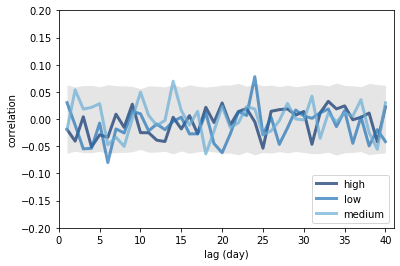

In [54]:
axis = [0, 41, -0.2, 0.2]

PlotAutoCorrelation(dailies, add_weekly=False)
thinkplot.Config(axis=axis, 
                     loc='lower right',
                     ylabel='correlation',
                     xlabel='lag (day)')

Here's what it would look like if there were a weekly cycle.

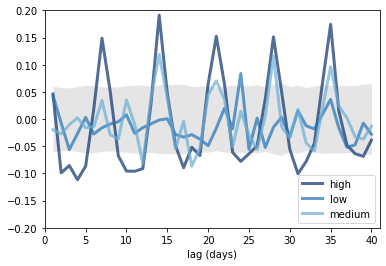

In [55]:
PlotAutoCorrelation(dailies, add_weekly=True)
thinkplot.Config(axis=axis,
                 loc='lower right',
                 xlabel='lag (days)')

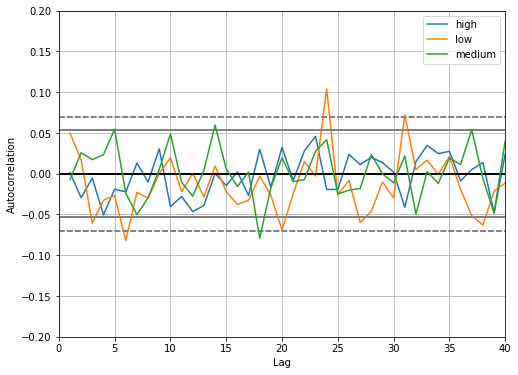

In [56]:
# Mine, just used pandas plotting autocorrelation
# This uses confidence intervals instead of simulation to find significant correlations
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.set_xlim(0,40)
ax.set_ylim(-.2,.2)

for name in my_filled.index.levels[0]:
    pd.plotting.autocorrelation_plot(my_filled.loc[name].resid, ax=ax, label=name)

ax.legend()

In [88]:
# For time series I'm only going to complete up to this point
# If I need to do prediction in the future I can do the part below
# Another method for prediction, exponential smoothing, is covered in Chap 4 of Data Analysis Using Open Source Tools book

## Prediction

The simplest way to generate predictions is to use `statsmodels` to fit a model to the data, then use the `predict` method from the results.

In [57]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

In [58]:
def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color='#ff7f00')
    xlim = years[0]-0.1, years[-1]+0.1
    thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)',
                 loc='upper right')

Here's what the prediction looks like for the high quality category, using the linear model.

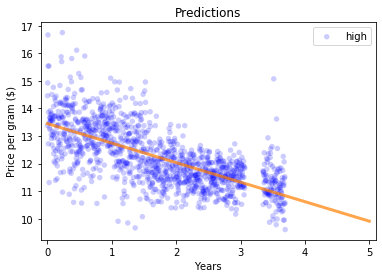

In [60]:
name = 'high'
daily = dailies[name]

_, results = RunLinearModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

When we generate predictions, we want to quatify the uncertainty in the prediction.  We can do that by resampling.  The following function fits a model to the data, computes residuals, then resamples from the residuals to general fake datasets.  It fits the same model to each fake dataset and returns a list of results.

In [61]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

To generate predictions, we take the list of results fitted to resampled data.  For each model, we use the `predict` method to generate predictions, and return a sequence of predictions.

If `add_resid` is true, we add resampled residuals to the predicted values, which generates predictions that include predictive uncertainty (due to random noise) as well as modeling uncertainty (due to random sampling).

In [62]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

To visualize predictions, I show a darker region that quantifies modeling uncertainty and a lighter region that quantifies predictive uncertainty.

In [63]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

Here are the results for the high quality category.

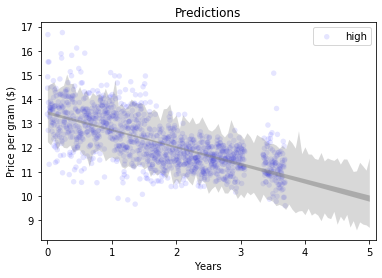

In [64]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

But there is one more source of uncertainty: how much past data should we use to build the model?

The following function generates a sequence of models based on different amounts of past data.

In [65]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

And this function plots the results.

In [66]:
def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')

Here's what the high quality category looks like if we take into account uncertainty about how much past data to use.

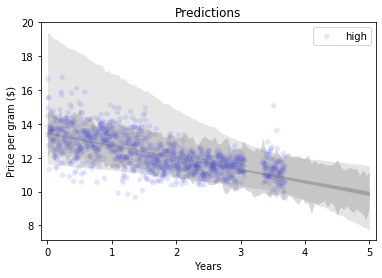

In [67]:
name = 'high'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)')

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [68]:
# Solution goes here

In [69]:
# Solution goes here

In [70]:
# Solution goes here

In [71]:
# Solution goes here

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [72]:
# Solution goes here

In [73]:
# Solution goes here

In [74]:
# Solution goes here

In [75]:
# Solution goes here

**Worked example:** There are several ways to extend the EWMA model to generate predictions. One of the simplest is something like this:

1. Compute the EWMA of the time series and use the last point as an intercept, `inter`.

2. Compute the EWMA of differences between successive elements in the time series and use the last point as a slope, `slope`.

3. To predict values at future times, compute `inter + slope * dt`, where `dt` is the difference between the time of the prediction and the time of the last observation.


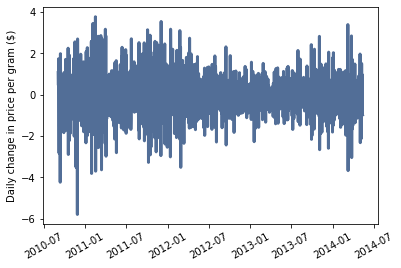

In [76]:
name = 'high'
daily = dailies[name]

filled = FillMissing(daily)
diffs = filled.ppg.diff()

thinkplot.plot(diffs)
plt.xticks(rotation=30)
thinkplot.Config(ylabel='Daily change in price per gram ($)')

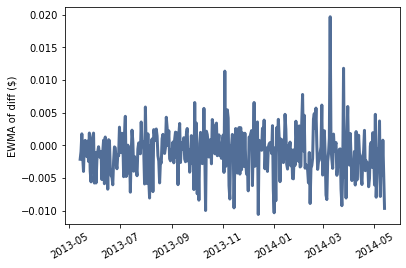

In [77]:
filled['slope'] = diffs.ewm(span=365).mean()
thinkplot.plot(filled.slope[-365:])
plt.xticks(rotation=30)
thinkplot.Config(ylabel='EWMA of diff ($)')

In [78]:
# extract the last inter and the mean of the last 30 slopes
start = filled.index[-1]
inter = filled.ewma[-1]
slope = filled.slope[-30:].mean()

start, inter, slope

(Timestamp('2014-05-13 00:00:00', freq='D'),
 10.92951876545549,
 -0.00252015473570003)

In [79]:
# reindex the DataFrame, adding a year to the end
dates = pd.date_range(filled.index.min(), 
                      filled.index.max() + np.timedelta64(365, 'D'))
predicted = filled.reindex(dates)

In [80]:
# generate predicted values and add them to the end
predicted['date'] = predicted.index
one_day = np.timedelta64(1, 'D')
predicted['days'] = (predicted.date - start) / one_day
predict = inter + slope * predicted.days
predicted.ewma.fillna(predict, inplace=True)

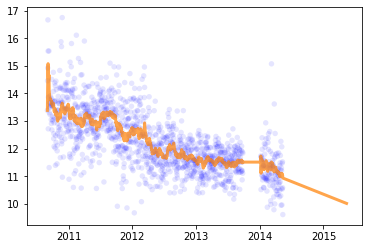

In [81]:
# plot the actual values and predictions
thinkplot.Scatter(daily.ppg, alpha=0.1, label=name)
thinkplot.Plot(predicted.ewma, color='#ff7f00')

As an exercise, run this analysis again for the other quality categories.